In [46]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from misc_funcs import get_samples
from dataset_specifications.dataset import LabelledData
from networks import NoiseInjection, FeedForward, DoubleInputNetwork
from cgan_versions import WCGAN
import seaborn as sns
import pandas as pd
import evaluation as eval
import scipy.stats as ss
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler


plt.rcParams.update({'font.size': 13})
plt.rc("axes", labelsize=18)
plt.rc("axes", titlesize=21)
plt.rc("legend", fontsize=18)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Gaussian mixtures
def mu1(x):
    return x+1 
def mu2(x):
    # return 2*x+1
    return 2*x+2.5
def mu3(x):
    return 4*x+5
def mu4(x):
    return 1.8*x+10

def std1(x): 
    return 0.2
def std2(x):
    # return np.sqrt(x+1.5)
    return 0.2+0.3*x
def std3(x):
    return 0.1+0.7*x
def std4(x):
    return 0.8-0.5*x
def pdf_func(x, x_supp, mixture_params, mixture_weights):
    y_pdf = np.zeros_like(x_supp)
    for (l, s), w in zip(mixture_params, mixture_weights):
        y_pdf += ss.norm.pdf(x_supp, loc=l(x), scale=s(x))*w
    return y_pdf

w = 0.65 #weight
n = 5000 #number of samples

In [29]:
mixture_params = np.array([[mu1,std1],[mu2, std2],[mu3,std3],[mu4,std4]])#
mixture_n_comp = mixture_params.shape[0]
mixture_weights = np.array([0.1,0.4,0.2,0.3])#,0.5*w,0.2*w
mixture_idx = np.random.choice(mixture_n_comp, size = n, p = mixture_weights)

In [30]:
# Sampling from GM
x_samples = np.random.uniform(low=0, high=1, size=n)
y_samples = []
for idx, i in enumerate(mixture_idx):
    mean = mixture_params[i,0]
    std = mixture_params[i,1]
    sample = ss.norm.rvs(loc=mean(x_samples[idx]), scale=std(x_samples[idx]))
    y_samples.append(sample)

In [31]:
# Make sure that GM from above corresponds to data imported below
combined = np.stack((x_samples, y_samples), axis=1)
combined_train, combined_test = model_selection.train_test_split(combined, test_size=0.3, random_state=43)

scaler = StandardScaler()
train_set_scaled = scaler.fit_transform(combined_train)
# Scale test data based on training data
test_set_scaled = scaler.transform(combined_test)

#export data
DATASET_PATH = './datasets'
DATASET_NAME = 'GM'

np.savetxt("./{}/{}/train.csv".format(DATASET_PATH,DATASET_NAME), train_set_scaled,delimiter=",")
np.savetxt("./{}/{}/val.csv".format(DATASET_PATH,DATASET_NAME), test_set_scaled,delimiter=",")

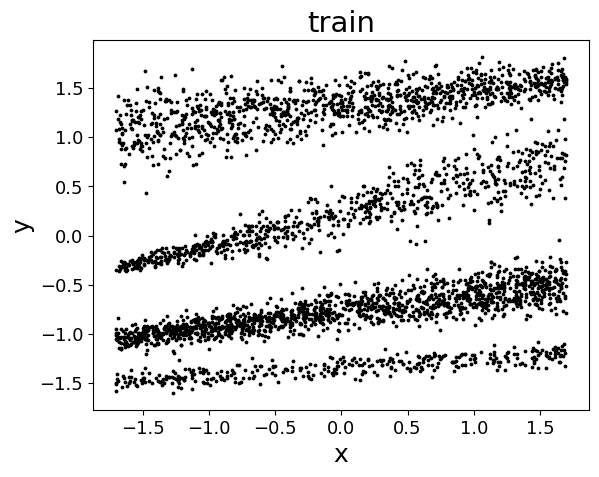

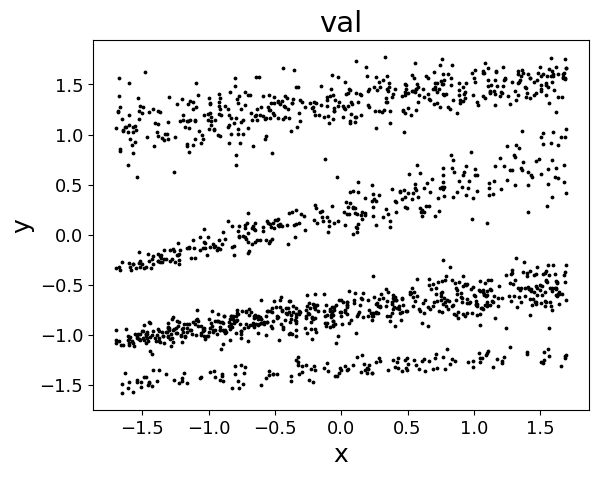

In [32]:
#import data
DATASET_PATH = './datasets'
DATASET_NAME = 'GM'
dataset_dir = os.path.join(DATASET_PATH,DATASET_NAME)
assert os.path.exists(dataset_dir),("dataset folder {} does not exist".format(dataset_dir))

splits = {}
#CHANGE DIMENSIONS OF DATA ACCORDINGLY
X_DIM = 1
Y_DIM = 1
scatter_plot = 1

for split in ("train","val"):
    data_path = os.path.join(dataset_dir,"{}.csv".format(split))
    assert os.path.exists(data_path),"data file {} does not exist".format(data_path)
    
    data = np.genfromtxt(data_path,delimiter=",")
    if scatter_plot:
        plt.figure
        plt.scatter(data[:,:1],data[:,1:], c='k', s=3)
        plt.xlabel("x")
        plt.ylabel('y')
        plt.title(split)
        plt.show()
    torch_data = torch.tensor(data, device="cpu").float()
    splits[split] = LabelledData(x=torch_data[:,:X_DIM],y=torch_data[:,X_DIM:])

train_data = splits["train"]
val_data = splits['val']

# train_tab = TabularDataset(train_data)
# train_tab[0]


In [33]:
# path for saving parameters of model
PARAM_PATH = './param_best'
FILE_NAME = '1D_GM_WCGAN'

# For saving plots
PLOT_PATH = './plots'
PLT_DATASET_NAME = '1D_GM'


constants = {
    "dataset_path": DATASET_PATH,
    "dataset_name": DATASET_NAME,
    # "channel_name": CHANNEL_NAME,
    "plot_path": PLOT_PATH,
    "plt_dataset_name": PLT_DATASET_NAME,
    "param_path": PARAM_PATH,
    "file_name": FILE_NAME,
    "x_dim": X_DIM,
    "y_dim": Y_DIM
}

In [9]:
def val_func(model, epoch):
    return eval.evaluate_model(model, data = val_data, data_train = train_data, data_test = None, epoch = epoch)

Epoch 49, true	ll: -1.4795	mae: 0.89558	Wasserstein-2 dist: 0.68883
Epoch 99, true	ll: -1.2562	mae: 0.87476	Wasserstein-2 dist: 0.18039
Epoch 149, true	ll: -1.1696	mae: 0.87422	Wasserstein-2 dist: 0.1532
Epoch 199, true	ll: -1.1311	mae: 0.86881	Wasserstein-2 dist: 0.11251
Epoch 249, true	ll: -1.0963	mae: 0.87048	Wasserstein-2 dist: 0.0983
Epoch 299, true	ll: -1.0541	mae: 0.87548	Wasserstein-2 dist: 0.098058
Epoch 349, true	ll: -1.0036	mae: 0.87823	Wasserstein-2 dist: 0.10568
Epoch 399, true	ll: -0.97503	mae: 0.87581	Wasserstein-2 dist: 0.087216
Epoch 449, true	ll: -0.96248	mae: 0.87712	Wasserstein-2 dist: 0.062433
Epoch 499, true	ll: -0.97769	mae: 0.87485	Wasserstein-2 dist: 0.048414
Epoch 549, true	ll: -0.9469	mae: 0.87269	Wasserstein-2 dist: 0.081078
Epoch 599, true	ll: -0.92673	mae: 0.87724	Wasserstein-2 dist: 0.090764
Epoch 649, true	ll: -0.92254	mae: 0.87561	Wasserstein-2 dist: 0.044549
Epoch 699, true	ll: -0.92625	mae: 0.87621	Wasserstein-2 dist: 0.050508
Epoch 749, true	ll: -0.9

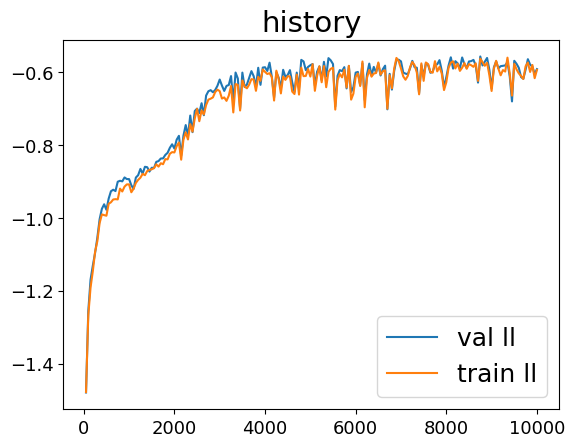

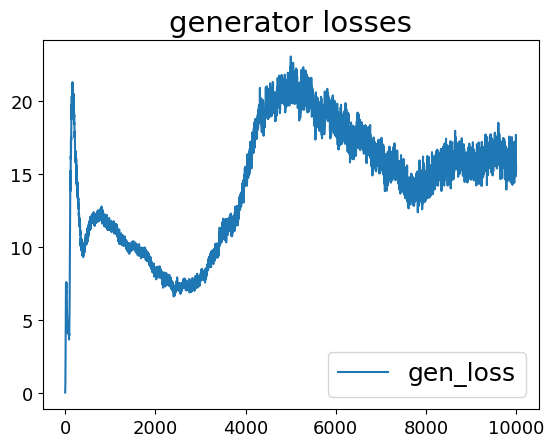

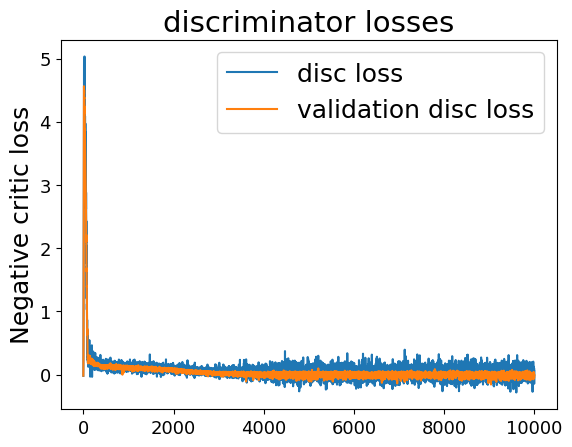

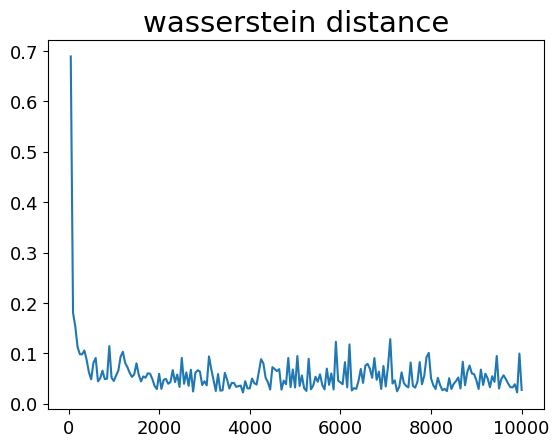

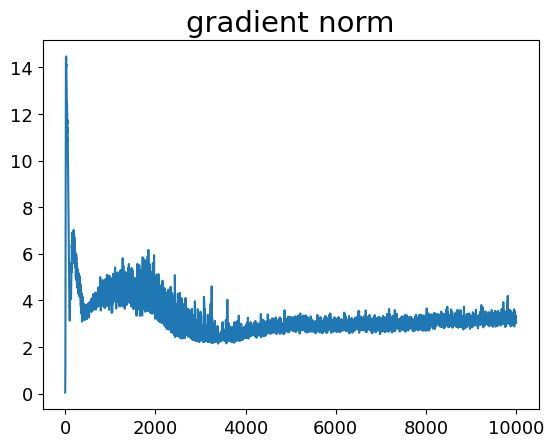

In [78]:
#create nn spec for discriminator and generator
config = {
    "noise_dim": 2,
    "epochs": 10000,
    "batch_size": 200,
    "gen_lr": 2e-4,
    "disc_lr": 2e-4,
    "val_interval": 50,
    "eval_batch_size": 1000,
    "eval_samples": 200,
    "kernel_scales": 50,
    "kernel_scale_min": 0.001,
    "kernel_scale_max": 0.5,
    "pdf_index":0,
    "scatter": 1,
    "kde_batch_size": 10,
    "n_critic": 20,
    "lambda_gp": 0.05,
    'one-sided': False
}
nn_spec = {'gen_spec' : {
    "other_dim": config["noise_dim"],#noise dimensions
    "cond_dim": X_DIM,#conditioning data
    "nodes_per_layer": [64,64,64,64],
    "output_dim": Y_DIM,#fake data dimensions
    "activation": nn.ReLU(),
    "type": NoiseInjection,
    "dropout":None,
    "activation_final": 0,
    "spectral_normalisation": None
},
'disc_spec': {
    "other_dim": Y_DIM,#actual data dimensions
    "cond_dim": X_DIM,    
    "nodes_per_layer": [64,64,64,64],
    # "cond_layers": [64],
    # "other_layers":[64],
    "output_dim": 1,#output logit
    "activation":nn.ReLU(),
    "type": FeedForward,
    "dropout": None,
    "activation_final": 0,
    "spectral_normalisation": None
}
}

wcgan_model = WCGAN(config, nn_spec, constants)
wcgan_model.train(train_data, val_data, val_func)

Text(0.5, 1.0, 'x=0.5')

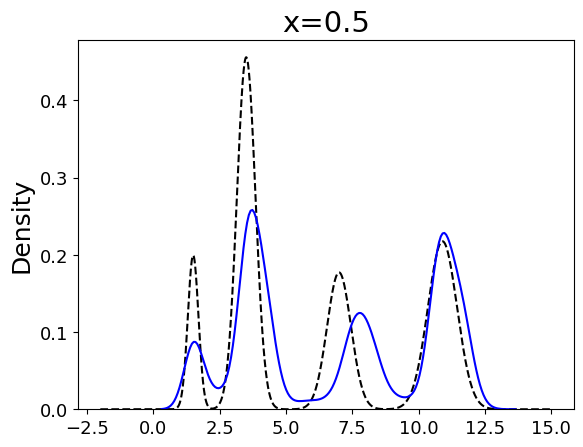

In [81]:
xs = 0.5
xs2 = 5 #unseen
x_pdf = np.linspace(-2,15,n)#support of pdf
x_pdf2 = np.linspace(-4,4,n)#support of pdf

y_pdf = pdf_func(xs,x_pdf,mixture_params, mixture_weights)
y_pdf2 = pdf_func(xs2,x_pdf2,mixture_params, mixture_weights)

y_train_mean = combined_train[:,1].mean()
y_train_std = np.std(combined_train[:,1])

# # Sample from model
y_gen = get_samples(wcgan_model,xs, num_samples=3000).numpy()
y_gen = y_gen*y_train_std+y_train_mean
plt.figure()
plt.plot(x_pdf, y_pdf, color ='k', linestyle='--',label='x={}'.format(xs))
sns.kdeplot(y_gen.squeeze(),color='b', bw_adjust=0.5)
plt.title('x={}'.format(xs))
# plt.figure()
# plt.plot(x_pdf2, y_pdf2, color ='k', linestyle='--')
# y_gen2 = get_samples(wcgan_model,xs2)
# sns.kdeplot(y_gen2.squeeze(),color='b', legend=True)
# plt.title('x={}'.format(xs2))

In [14]:
param_dir = os.path.join(constants['param_path'],constants['file_name'],"epoch_best.pt")

checkpoint = torch.load(param_dir, map_location=wcgan_model.device)
wcgan_model.critic.load_state_dict(checkpoint["disc"])
if "gen" in checkpoint:
    wcgan_model.gen.load_state_dict(checkpoint["gen"])

array([1.2022413], dtype=float32)

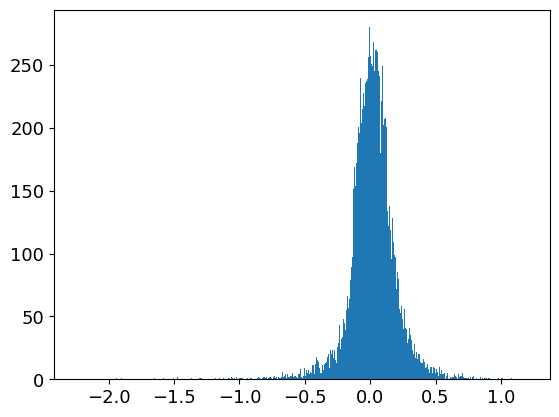

In [80]:
critic_weights = []
for name, param in wcgan_model.critic.named_parameters():
    if 'weight' in name:
        critic_weights.append(param.detach().numpy())
for i, w in enumerate(critic_weights):
    # if i == 0:
    #     tmp = np.array(w)
    # else:
    #     tmp = np.concatenate((tmp,w), a)
    w = w.reshape(-1,1)
    critic_weights[i] = w
    if i == 0:
        tmp = np.array(critic_weights[i])
    else:
        tmp = np.concatenate((tmp, critic_weights[i]))
plt.figure()
plt.hist(tmp, bins = 500)
max(tmp)
# plt.figure()
# plt.plot(wcgan_model.gradient_norm)
# plt.plot(wcgan_model.gradient_norm_val)